In [18]:
# DEFINITIONS

# METHODS
# Trust_Region = structure for trust region seach - specify functions + params
# Line_Search = basic line seach - specify parameters
# BFGS = linesearch using an estimateion of hessian
# F = function method
# Gradient = gradient method of F
# Hessian = hessian method of F
# X_Next = finds the next proprosed point for x
# Quad_Model = model function used in trust region (uses real hessian)
# Quat_Model_P = finds p by optimizing Quad_Model and p_mag = min(radius, p)
# Cauchy_P = finds p by optimizing Quad_Model and scaling by tau
# Rho = calculates ratio of model to actual function to determine how to proceed in trust region algo
# Tau_Quadratic = calculates tau for two vectors used to step at full length of radius in trust region algo
# Dogleg_P = finds p by trading off between newton and gradient descent
# CG_Steihaug_P = finds p using Conjugate Gradient methods
# Hilbert = creates an nxn Hilbert matrix with elements = 1/(i+j-1) where i,j=1,2,..,n
# CG = standard Conjugate Gradient method to minimize ||r|| = ||Ax - b|| to solve Ax = b
# Estimate_Iters = estimates how many iterations CG will take based on the eigenvalue distribution of A
# Phi = univariate function - f value at next proprosed point
# Phi_Prime = gradient of Phi with respect to alpha
# Sufficient_Decrease = Wofle condition 1, checks if proposed point is decreasing Phi enough
# Sufficient_Decrease2 = in terms of phi
# Curvature_Condition = Wolfe condition 2, checks is slope is near enough to 0 for proposed step size
# Curvature_Condition2 = in terms of phi
# Golstein_Conditions = sufficient decrease, except is checks that alpha is not too small
# Safeguard = bisects alpha guess if alpha is too close to edges
# Backtracking_Alpha = reduces alpha by a constant until sufficient decrease is met
# Interpolate_Alpha = finds optimal alpha with iterative quadratic and cubic interpolations (assumes expensive derivatives)
# Interpolate_Alpha2 = finds optimal alpha with iterative quadratic and cubic interpolations (assumes cheap derivatives)
# Zoom - finds alpha that meets wolfe conditions in interval
# Quadratic_Interpolation = interpolates between 0 and guess of alpha using a quadratic, then minimizes alpha with it
# Cubic_Interpolation = interpolates between 0 and two guesses of alpha using a cubic, then minimizes alpha with it
# Cubic_Hermite_Interpolation = w/ derivatives (assuming it is cheap enough to calculate)
# Newton_Alpha0 = how to pick initial guess of alpha using (Quasi-)Newton methods
# Strategy1_Alpha0 or Strategy2_Alpha0 = how to pick initial guess of alpha using steepest descent and conjugate gradient methods
# Wolfe_Alpha = iterates through finding optimal alpha intervals using wolfe condtions 
    # (use helper function to specify strategy to pick alpha1)
# Steepest_Descent = calculates direction p by using the gradient
# Newton_P = calculates direction p by using both the hessian and gradient

# VARIABLES
# (lower case var of method is the output of that method)
# x = current value of x (vector)
# f = function value at current x (scalar)
# gradient = gradient value at current x (vector)
# hessian = hessian value at current x (matrix)
# var_T = transpose of variable-matrix (vector or matrix)
# var_I = inverse of variable-matrix (matrix)
# var_# = output value of function defined at given # (scalar or vector or matrix)
# var0 = most recent guess of value (var_i)
# var1 = next guess of value (var_i+1)
# p = direction to move in line search
# alpha = step size to move in direction p

# REFERENCES
# Nocedal, Jorge, and Stephen J. Wright. Numerical optimization. New York: Springer, 2006. Print.
# p.# refers to page number in above book

In [2]:
import numpy as np
from math import sqrt as sqrt
from math import log as log
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d

In [3]:
# dfine functions here to optimize
# always need to define the gradient method as well
# depending on the method you use, you may need to also define the hessian
def F_Rosenbrock(x):
    return 100 * (x[1] - x[0]**2)**2 + (1-x[0])**2
def Gradient_Rosenbrock(x):
    dx1 = -400*(x[1]-x[0]**2)*x[0] - 2*(1-x[0])
    dx2 = 200*(x[1]-x[0]**2)
    return np.array([dx1, dx2])
def Hessian_Rosenbrock(x):
    dx1dx1 = -400*x[1] + 1200*x[0]**2+2
    dx2dx1 = -400*x[0]
    dx1dx2 = -400*x[0]
    dx2dx2 = 200
    return np.array([[dx1dx1, dx2dx1], [dx1dx2, dx2dx2]])
# N-Dimensional versions of rosenbrock
def F_Rosenbrock_ND(x):
    total = 0
    i = 0
    for i in range(0, len(x), 2):
        total += 100 * (x[i+1] - x[i+0]**2)**2 + (1-x[i+0])**2
    return total
def Gradient_Rosenbrock_ND(x):
    jacobean = np.zeros(len(x))
    i = 0
    for i in range(0, len(x), 2):
        jacobean[i]   = dx1 = -400*(x[i+1]-x[i+0]**2)*x[i+0] - 2*(1-x[i+0])
        jacobean[i+1] = dx2 = 200*(x[i+1]-x[i+0]**2)
    return jacobean
def Hessian_Rosenbrock_ND(x):
    hessian = np.zeros((len(x), len(x)))
    for i in range(0, len(x), 2):
        hessian[i, i] = dx1dx1 = -400*x[i+1] + 1200*x[i+0]**2+2
        hessian[i, i+1] = dx2dx1 = -400*x[i+0]
        hessian[i+1, i] = dx1dx2 = -400*x[i+0]
        hessian[i+1, i+1] = dx2dx2 = 200
    return hessian

In [4]:
# used to calculate next grid point values
def X_Next(x, alpha, p):
    return x + alpha * p
def Phi(F, x_next): #p.56
    return F(x_next)
def Phi_Prime(gradient_next_T, p):
    return np.dot(gradient_next_T, p)

In [5]:
# condition methods
# using direct values (expensive)...
def Sufficient_Decrease(f_next, f, c1, alpha, gradient_T, p): #p.33
    return f_next <= f + c1 * alpha * np.dot(gradient_T, p)
# using univariate functions (cheap)...
def Sufficient_Decrease2(phi_alpha, phi_0, c1, alpha, phi_prime_0): #p.57
    return phi_alpha <= phi_0 + c1 * alpha * phi_prime_0
def Curvature_Condition(gradient_next_T, p, c2, gradient_T): #p.33
    return np.dot(gradient_next_T, p) >= c2 * np.dot(gradient_T, p)
def Curvature_Condition2(phi_prime_alpha, c2, phi_prime_0): #p.33
    return abs(phi_prime_alpha) <= -1*c2*phi_prime_0
def Goldstein_Conditions(f, c, alpha, gradient_T, p, f_next): #p.36
    return f + (1-c)*alpha*np.dot(gradient_T, p) <= f_next <= f + c*alpha*np.dot(gradient_T, p)

In [6]:
# check if we are making sufficient progress (0 is last guess, 1 is current guess, last is boundary alpha - min or max)
def Safeguard(alphaMin, alphaMax, alpha, epsilon):
    if abs(alphaMin - alpha) < epsilon or abs(alphaMax - alpha) < epsilon:
        alpha = (alphaMin + alphaMax) / 2
    return alpha
# interpolation methods - get optimal alpha within given range
def Quadratic_Interpolation(phi_0, phi_prime_0, phi_alpha0, alpha0): #p.58
    return -1. * phi_prime_0 * alpha0**2 / ( 2*(phi_alpha0 - phi_0 - phi_prime_0 * alpha0) )
# cubic interpolation usually has quadratic convergence for alpha...
# assuming derivatives are expensive to use...
def Cubic_Interpolation(alpha0, phi_alpha0, phi_0, phi_prime_0, alpha1, phi_alpha1): #p.58
    c = 1 / ((alpha0**2 * alpha1**2)*(alpha1-alpha0))
    A = np.array([[alpha0**2, -1*alpha1**2], 
                  [-1*alpha0**3, alpha1**3]])
    B = np.array([phi_alpha1 - phi_0 - phi_prime_0*alpha1,
                  phi_alpha0 - phi_0 - phi_prime_0*alpha0])
    ab = c * np.dot(A, B)
    a = ab[0]
    b = ab[1]
    return (-1*b + sqrt(b**2 - 3*a*phi_prime_0)) / (3*a)
# assuming derivatives are cheap enough to use...
# I used this nomenclature, following book = mine: alpha_i = alpha1    and    alpha_i-1 = alpha0
def Cubic_Hermite_Interpolation(alpha0, phi_alpha0, phi_prime_alpha0, alpha1, phi_alpha1, phi_prime_alpha1): #p.59
    d1 = phi_prime_alpha0 + phi_prime_alpha1 - 3 * (phi_alpha0 - phi_alpha1) / (alpha0 - alpha1)
    d2 = np.sign(alpha1 - alpha0) * sqrt(max(0, d1**2 - phi_prime_alpha0 * phi_prime_alpha1))
    return alpha1 - (alpha1 - alpha0) * ( (phi_prime_alpha1 + d2 - d1) / (phi_prime_alpha1 - phi_prime_alpha0 + 2*d2) )
# zoom function used with wWolfe_Alpha
def Zoom(alphaLo, phi_alphaLo, phi_prime_alphaLo, alphaHi, phi_alphaHi, phi_prime_alphaHi, F, x, p, Gradient,
         phi_0, c1, phi_prime_0, c2, epsilon): #p.61
    i = 0
    while(True):
        # get a trial step with interpolation
        alpha2 = Cubic_Hermite_Interpolation(alphaLo, phi_alphaLo, phi_prime_alphaLo
                                             , alphaHi, phi_alphaHi, phi_prime_alphaHi)
        # check safeguard
        alpha2 = Safeguard(alphaLo, alphaHi, alpha2, epsilon)
        # get phi at this trial step
        x2 = X_Next(x, alpha2, p)
        phi_alpha2 = Phi(F, x2)
        # since we are suing cubic hermite we need the gradient no matter what
        gradient_T_alpha2 = np.transpose(Gradient(x2))
        phi_prime_alpha2 = Phi_Prime(gradient_T_alpha2, p)
        # check if we need a new hi to satisfy sufficient decrease
        if not Sufficient_Decrease2(phi_alpha2, phi_0, c1, alpha2, phi_prime_0) or phi_alpha2 >= phi_alphaLo:
            alphaHi = alpha2
            phi_alphaHi = phi_alpha2
            phi_prime_alphaHi = phi_prime_alpha2
        else:
            # check curvature to satisfy both wolfe conditions
            if Curvature_Condition2(phi_prime_alpha2, c2, phi_prime_0):
                return alpha2 # GOAL
            # check condition (c) on p.61, to see if we have a new high
            if phi_prime_alpha2 * (alphaHi-alphaLo) >= 0:
                alphaHi = alphaLo
                phi_alphaHi = phi_alphaLo
                phi_prime_alphaHi = phi_prime_alphaLo
            # otherwise alpha2 is our new low
            alphaLo = alpha2
            phi_alphaLo = phi_alpha2
            phi_prime_alphaLo = phi_prime_alpha2
        i+=1

In [7]:
# direction methods - return optimized p direction to move in
def Steepest_Descent(gradient): #p.21
    return -1. * gradient / np.linalg.norm(gradient, ord=2)
def Newton_P(hessian_I, gradient): #p.22
    return -1.* np.dot(hessian_I, gradient)

In [8]:
# methods to find alpha0 - initial guess of alpha
# use alpha0=1 for (Quasi-)Newton methods to optimize rate of convergence...
def Newton_Alpha0(): #p.59
    return 1
# for steepest descent and conjugate gradient methods use either of the 2 below...
# strategy 1 assumes 1st-order change between subsequent function values at given best alphas
def Strategy1_Alpha0(alpha_last, gradient_last_T, p_last, gradient_T, p): #p.59
    return alpha_last * np.dot(gradient_last_T, p_last) / np.dot(gradient_T, p)
# strategy 2 interpolates a quadratic to estimate alpha*
def Strategy2_Alpha0(f, f_last, phi_prime_0): #p.59
    return 2 * (f - f_last) / phi_prime_0

In [9]:
# methods to find alpha* - estimated optimal value of alpha
# multiply alpha by a constant < 1 until sufficient decrease is met
def Backtracking_Alpha(rho, f, c1, alpha0, gradient_T, p, x): #p.37
    alpha = alpha0
    x_next = X_Next(x, alpha, p)
    f_next = F(x_next)
    iters = 0
    while not Sufficient_Decrease(f_next, f, c1, alpha, gradient_T, p):
        alpha = rho * alpha
        x_next = X_Next(x, alpha, p)
        f_next = F(x_next)
        iters += 1
    return alpha, iters
# interpolative method to find best alpha between 0 and initial guess if derivatives are expensive...
def Interpolate_Alpha(phi_0, phi_prime_0, phi_alpha0, alpha0, c1, F, x, p): #p.57-58
    # check if initial alpha guess (alpha0) is good
    if Sufficient_Decrease2(phi_alpha0, phi_0, c1, alpha0, phi_prime_0):
        return alpha0
    # get quadratic interpolation between [0, alpha0] using {0, alpha0}
    alpha1 = Quadratic_Interpolation(phi_0, phi_prime_0, phi_alpha0, alpha0)
    # check if next alpha guess (alpha1) is good
    if Sufficient_Decrease2(phi_alpha0, phi_0, c1, alpha1, phi_prime_0):
        return alpha1
    # get cubic interpolation between [0, alpha0] using {0, alpha0, alpha1}
    x1 = X_Next(x, alpha1, p)
    phi_alpha1 = Phi(F, x1)
    alpha2 = Cubic_Interpolation(phi_0, phi_prime_0, phi_alpha0, alpha0, phi_alpha1, alpha1)
    # check if next alpha guess (alpha2) is good
    # otherwise iteraviely repeat cubic interpolation with next two recent alpha guesses until good
    while not Sufficient_Decrease2(phi, phi_0, c1, alpha2, phi_prime_0):
        # check if we need to reset our guess of alpha (can change constant parameters in boolean expression as needed)
        # this can happen if alpha2 is too close to alpha1 or if alpha2 is too far from alpha1
        if alpha1 - alpha2 < alpha1 / 8 or alpha1 - alpha2 > alpha1 - alpha1 / 8:
            alpha2 = alpha1 / 2
        # calculate next values needed for cubic interpolation
        # set last guess (1) to initial guess (0)
        alpha0 = alpha1
        phi_alpha0 = phi_alpha1
        # set new guess (2) to last guess (1) and get needed variables
        alpha1 = alpha2
        x1 = X_Next(x, alpha1, p)
        phi_alpha1 = Phi(F, x1)
        # get new guess (2)
        # get cubic interpolation between [0, alpha0] using {0, alpha0, alpha1} with new values {alpha0, alpha1}
        alpha2 = Cubic_Interpolation(phi_0, phi_prime_0, phi_alpha0, alpha0, phi_alpha1, alpha1)
    return alpha2
# interpolative method to find best alpha between 0 and initial guess if derivatives are cheap...
def Interpolate_Alpha2(phi_0, phi_prime_0, phi_alpha0, alpha0, c1, F, x, p, Gradient): #p.57-59
    # check if initial alpha guess (alpha0) is good
    if Sufficient_Decrease2(phi_alpha0, phi_0, c1, alpha0, phi_prime_0):
        return alpha0
    # get quadratic interpolation between [0, alpha0] using {0, alpha0}
    alpha1 = Quadratic_Interpolation(phi_0, phi_prime_0, phi_alpha0, alpha0)
    # check if next alpha guess (alpha1) is good
    if Sufficient_Decrease2(phi_alpha0, phi_0, c1, alpha1, phi_prime_0):
        return alpha1
    # get cubic interpolation between [0, alpha0] using {0, alpha0, alpha1}
    x0 = X_next(x, alpha0, p)
    gradient_T_alpha0 = np.transpose(Gradient(x0))
    phi_prime_alpha0 = Phi_Prime(gradient_T_alpha0, p)
    x1 = X_Next(x, alpha1, p)
    phi_alpha1 = Phi(F, x1)
    gradient_T_alpha1 = np.transpose(Gradient(x1))
    phi_prime_alpha1 = Phi_Prime(gradient_T_alpha1, p)
    alpha2 = Cubic_Hermite_Interpolation(alpha0, phi_alpha0, phi_prime_alpha0, alpha1, phi_alpha1, phi_prime_alpha1)
    # check if new guess (alpha2) is good
    # otherwise iteraviely repeat cubic interpolation with next two recent alpha guesses until good
    while not Sufficient_Decrease2(phi, phi_0, c1, alpha2, phi_prime_0):
        # check if we need to reset our guess of alpha (can change constant parameters in boolean expression as needed)
        # this can happen if alpha2 is too close to alpha1 or if alpha2 is too far from alpha1
        if alpha1 - alpha2 < alpha1 / 8 or alpha1 - alpha2 > alpha1 - alpha1 / 8:
            alpha2 = alpha1 / 2
        # calculate next values needed for cubic interpolation
        # set last guess (1) to initial guess (0)
        alpha0 = alpha1
        phi_alpha0 = phi_alpha1
        phi_prime_alpha0 = phi_prime_alpha1
        # set new guess (2) to last guess (1) and get needed variables
        alpha1 = alpha2
        x1 = X_Next(x, alpha1, p)
        phi_alpha1 = Phi(F, x1)
        gradient_T_alpha1 = np.transpose(Gradient(x1))
        phi_prime_alpha1 = Phi_Prime(gradient_T_alpha1, p)
        # get new guess (2)
        # get cubic interpolation between [0, alpha0] using {0, alpha0, alpha1} with new values {alpha0, alpha1}
        alpha2 = Cubic_Hermite_Interpolation(alpha0, phi_alpha0, phi_prime_alpha0, alpha1, phi_alpha1, phi_prime_alpha1)
    return alpha2
# use strong wolfe conditions and zoom function to find best alpha
# strategy 1 to guess alpha1
def Wolfe_Alpha_Strategy1(alphaMax, x, p, F, f, phi_0, c1, c2, phi_prime_0, Gradient, epsilon
                          ,alpha_last, gradient_last_T, p_last, gradient_T, counter):
    if counter == 0:
        alpha1 = 1
    else:
        alpha1 = Strategy1_Alpha0(alpha_last, gradient_last_T, p_last, gradient_T, p)
    return Wolfe_Alpha(alphaMax, x, p, F, f, phi_0, c1, c2, phi_prime_0, Gradient, epsilon, alpha1)
# strategy 2 to guess alpha1
def Wolfe_Alpha_Strategy2(alphaMax, x, p, F, f, phi_0, c1, c2, phi_prime_0, Gradient, epsilon, f_last, counter):
    if counter == 0:
        alpha1 = 1
    else:
        alpha1 = min(1, 1.01*Strategy2_Alpha0(f, f_last, phi_prime_0))
    return Wolfe_Alpha(alphaMax, x, p, F, f, phi_0, c1, c2, phi_prime_0, Gradient, epsilon, alpha1)
# strategy for Newton to guess alpha1
def Wolfe_Alpha_StrategyNewton(alphaMax, x, p, F, f, phi_0, c1, c2, phi_prime_0, Gradient, epsilon):
    alpha1 = 1
    return Wolfe_Alpha(alphaMax, x, p, F, f, phi_0, c1, c2, phi_prime_0, Gradient, epsilon, alpha1)
# with a guess of alpha1
def Wolfe_Alpha(alphaMax, x, p, F, f, phi_0, c1, c2, phi_prime_0, Gradient, epsilon, alpha1):  #p.60
    # use 0 for first guess
    alpha0 = 0 
    x0 = X_Next(x, alpha0, p)
    phi_alpha0 = Phi(F, x0)
    # since we are using Hermite Cubic, we need the gradient no matter what
    gradient_T_alpha0 = np.transpose(Gradient(x0))
    phi_prime_alpha0 = Phi_Prime(gradient_T_alpha0, p)
    i = 1
    # alpha1 is current guess and alpha0 is last guess
    while(True):
        # get next guess values
        x1 = X_Next(x, alpha1, p)
        phi_alpha1 = Phi(F, x1)
        # since we are using Hermite Cubic, we need the gradient no matter what
        gradient_T_alpha1 = np.transpose(Gradient(x1))
        phi_prime_alpha1 = Phi_Prime(gradient_T_alpha1, p)
        # check sufficient decrease
        if ( not Sufficient_Decrease2(phi_alpha1, phi_0, c1, alpha1, phi_prime_0)
        or (i > 1 and phi_alpha1 >= phi_alpha0) ):
            return Zoom(alpha0, phi_alpha0, phi_prime_alpha0
                        , alpha1, phi_alpha1, phi_prime_alpha1
                        , F, x, p, Gradient, phi_0, c1, phi_prime_0, c2, epsilon), i
        # check curvature, then both wolfe conditions are satisfied and no need for zoom
        if abs(phi_prime_alpha1) <= -1 * c2 * phi_prime_0:
            return alpha1, i # GOAL 
        # check if positive gradient
        if phi_prime_alpha1 >= 0:
            return Zoom(alpha1, phi_alpha1, phi_prime_alpha1
                        , alpha0, phi_alpha0, phi_prime_alpha0
                        , F, x, p, Gradient, phi_0, c1, phi_prime_0, c2, epsilon), i
        # get next guess (bisect between alpha1 and alphaMax)
        alphaNext = (alphaMax + alpha1)/2
        # check safegaurd
        if epsilon != 0 and abs(alphaNext - alpha1) < epsilon:
            alphaNext = alpha1/2
        # move up other values
        alpha0 = alpha1
        phi_alpha0 = phi_alpha1
        phi_prime_alpha0 = phi_prime_alpha1
        alpha1 = alphaNext
        x0 = x1
        i += 1

In [10]:
# methods for model functions in trust regions
def Rho(Model, F, x, p, f, gradient_T, hessian):
    return (f - F(x + p)) / (Model(f, gradient_T, np.zeros(p.shape), hessian) - Model(f, gradient_T, p, hessian))
def Quad_Model(f, gradient_T, p, hessian):
    return f + np.dot(gradient_T, p) + 0.5*np.dot(np.transpose(p), np.dot(hessian, p))
def Quad_Model_P(gradient, hessian_I, radius):
    p = -1. * np.dot(hessian_I, gradient)
    p_mag = np.linalg.norm(p, ord=2)
    if p_mag > radius:
        return p * radius / p_mag
    return p
def Cauchy_P(gradient, gradient_T, hessian, radius, gradient_mag):
    gBg = np.dot(gradient_T, np.dot(hessian, gradient))
    tau = 1 if gBg <=0 else min(gradient_mag**3/(radius*gBg), 1)
    return -1. * tau * radius * gradient / gradient_mag
def Tau_Quadratic(v1, v2, radius):
    a = np.dot(v1, v1)
    b = 2*np.dot(v1, v2)
    c = np.dot(v2, v2) - radius**2
    term = sqrt(b**2 - 4*a*c)
    tau = (-b+term)/(2*a)
    return tau
def Dogleg_P(gradient, gradient_T, hessian_I, hessian, radius):
    gg = np.dot(gradient_T, gradient)
    gBg = np.dot(gradient_T, np.dot(hessian, gradient))
    p_u = -1. * (gg / gBg) * gradient
    p_u_mag = np.linalg.norm(p_u, ord=2)
    if p_u_mag >= radius:
        return radius * p_u / p_u_mag
    p_f = -1. * np.dot(hessian_I, gradient)
    p_f_mag = np.linalg.norm(p_f, ord=2)
    if p_f_mag <= radius:
        return p_f
    p_fu = p_f - p_u
    tau = 1 + Tau_Quadratic(p_fu, p_u, radius)
    return p_u + (tau-1) * p_fu
# p.171
def CG_Steihaug_P(gradient, gradient_mag, hessian, eps_k, radius, x, counter):
    if gradient_mag < eps_k:
        return np.zeros(x.shape)
    
    z0 = 0
    r0 = gradient
    d0 = -1. * r0
    j = 0
    B = hessian # use real value of Hessian
    while(True):
        Bd = np.dot(B, d0)
        dBd = np.dot(np.transpose(d0), Bd)
        if dBd <= 0:
            print('negative curvature at iteration', counter)
            # find tau such that p_mag=radius
            tau = Tau_Quadratic(d0, z0, radius)
            p = z0 + tau*d0
            return p
        alpha0 = np.dot(r0, r0) / dBd
        z1 = z0 + alpha0 * d0
        z1_mag = np.linalg.norm(z1, ord=2)
        if z1_mag >= radius:
            print('reached trust region boundary at iteration', counter)
            # find tau such that p_mag=radius
            tau = Tau_Quadratic(d0, z0, radius)
            p = z0 + tau*d0
            return p
        r1 = r0 + alpha0*np.dot(B, d0)
        r1_mag = np.linalg.norm(r1, ord=2)
        if r1_mag < eps_k:
            print('reached stopping criteria at iteration', counter)
            p = z1
            return p
        r0r0 = np.dot(np.transpose(r0), r0)
        r1r1 = np.dot(np.transpose(r1), r1)
        beta1 = r1r1 / r0r0
        d1 = -1. * r1 + beta1 * d0
        
        # prepare for next iter
        z0 = z1
        r0 = r1
        d0 = d1
        j += 1

In [11]:
# variable methods ( so that we do not recalculate variables when we need them, and keeps methods obfuscated )
import inspect
def Get_Variables(foo):
    return inspect.getfullargspec(foo)[0]
def Fetch(variable, variables, variables_last):
    if variable not in variables:
        def dFetch(variable):
            return Fetch(variable, variables, variables_last)
        if variable == 'gradient': v = variables['Gradient'](variables['x'])
        elif variable == 'gradient_mag': v = np.linalg.norm(dFetch('gradient'), ord=2)
        elif variable == 'hessian': v = variables['Hessian'](variables['x'])
        elif variable == 'hessian_I': v = np.linalg.inv( dFetch('hessian') )
        elif variable == 'alpha_last': v = variables_last['alpha']
        elif variable == 'gradient_last_T': 
            if 'gradient_T' in variables_last: v = variables_last['gradient_T']
            else: v = np.transpose(variables_last['gradient'])
        elif variable == 'p_last': v = variables_last['p']
        elif variable == 'gradient_T': v = np.transpose(dFetch('gradient'))
        elif variable == 'f_last': v = variables_last['f']
        elif variable == 'phi_prime_0': v = Phi_Prime(dFetch('gradient_T'), variables['p'])
        elif variable == 'phi_0': v = variables['f']
        elif variable == 'phi_alpha0': v = Phi(variables['F'], X_Next(variables['x'], variables['alpha0'], variables['p']))
        elif variable == '': v = variables['']
        variables[variable] = v
    return variables[variable]
def Calculate_Variables(variables, variables_last, method):
    return {variable:Fetch(variable, variables, variables_last) for variable in Get_Variables(method)}

In [12]:
# skeleton for line search methods - pass in parameters when using library
def Line_Search(F, Gradient, Hessian, P, Alpha, tolerance, x, params={}):
    counter = 0
    results = {}
    f = F(x)
    results[counter] = [x.copy(), f, 1]
    variables_last = {}
    print('[inner_itertions, f(x), alpha, ||∇f(x*)||]')
    total_inner = 0
    while f >= tolerance and counter < 100_000:
        # reset variables for this iteration
        variables = {'x':x, 'f':f, 'F':F, 'Gradient':Gradient, 'Hessian':Hessian, 'counter':counter}
        for param in params:
            variables[param] = params[param]
        if counter == 0:
            # find direction p
            p = variables['p'] = P(**Calculate_Variables(variables, variables, P))
            # find step size alpha
            variables['alpha'] = 1
            alpha, inner_iterations = Alpha(**Calculate_Variables(variables, variables, Alpha))
            variables['alpha'] = alpha
        else:
            # find direction p
            p = variables['p'] = P(**Calculate_Variables(variables, variables_last, P))
            # find step size alpha
            alpha, inner_iterations = Alpha(**Calculate_Variables(variables, variables_last, Alpha))
            variables['alpha'] = alpha
        total_inner += inner_iterations
        # take step and calculate
        x = X_Next(x, alpha, p)
        f = F(x)
        counter +=1
        results[counter] = [x.copy(), f, alpha]
        variables_last = variables.copy()
        #print(results[counter])
    print()
    print(f'total_inner_iters={total_inner} total_outer_iters={counter} final_f(x*)={f}')
    return results

In [13]:
# skeleton for trust region methods - pass in parameters when using library
def Trust_Region(F, Gradient, Hessian, x, tolerance
                 , radiusMax, radius, eta, Model, P,
                 c1, c2, c3, c4,
                params={}, verbose=0):
    counter = 0
    results = {}
    f = F(x)
    gradient_mag = np.linalg.norm(Gradient(x), ord=2)
    results[counter] = [x.copy(), f, gradient_mag, radius, 0]
    variables_last = {}
    while gradient_mag >= tolerance and counter < 100_000:
        # reset variables for this iteration
        variables = {'x':x, 'f':f, 'F':F, 'Gradient':Gradient, 'Hessian':Hessian
                     , 'Model':Model, 'radius':radius, 'counter':counter}
        for param in params:
            variables[param] = params[param]
        # find direction p
        p = variables['p'] = P(**Calculate_Variables(variables, variables_last, P))
        # get rho (ratio of changes in function value to model value)
        rho = variables['rho'] = Rho(**Calculate_Variables(variables, variables_last, Rho))
        # round to avoid floating precision error when using boolean operators
        p_mag = round(np.linalg.norm(p, ord=2), 8)
        if verbose > 0:
            print(f'rho={round(rho,4)}, del={round(radius,4)}, p_norm={round(p_mag,4)}')
        # evaluate at given values
        if rho < c1:
            radius *= c2
        else:
            if rho > c3 and p_mag == radius:
                radius = min(c4*radius, radiusMax)
        if rho > eta:
            x = X_Next(x, 1, p)
        f = F(x)
        gradient_mag = Fetch('gradient_mag', variables, variables_last)
        counter +=1
        results[counter] = [x.copy(), f, gradient_mag, radius, rho]
        variables_last = variables.copy()
        if counter >= 10000:
            print('did not converge wihtin 10k iters')
            break
    print(f'minimizer={x} iterations={counter} ||∇f(x*)||={round(gradient_mag,4)}')
    return results

In [14]:
# BFGS that uses line search but estimates hessian - pass in parameters when using library
def BFGS(F, Gradient, Hessian, hessian0, P, Alpha, tolerance, x, params={}):
    counter = 0
    results = {}
    f = F(x)
    #g = np.linalg.norm(Gradient(x), ord=2)
    results[counter] = [x.copy(), f, 1]
    variables_last = {}
    print('[inner_itertions, f(x), alpha, ||∇f(x*)||, 1e]')
    total_inner = 0
    finish = False
    while f >= tolerance and counter < 100_000:
        # reset variables for this iteration
        variables = {'x':x, 'f':f, 'F':F, 'Gradient':Gradient, 'hessian_I':hessian0, 'counter':counter}
        for param in params:
            variables[param] = params[param]
        # find direction p
        p = variables['p'] = P(**Calculate_Variables(variables, variables_last, P))
        # find step size alpha
        alpha, inner_iterations = Alpha(**Calculate_Variables(variables, variables_last, Alpha))
        variables['alpha'] = alpha
        total_inner += inner_iterations
        # take step and calculate
        x = X_Next(x, alpha, p)
        s = x - variables['x']
        y = Gradient(x) - Fetch('gradient', variables, variables_last)
        yTs = np.dot(y, s)
        if yTs >= 1e-10: # sometimes this will shrink to zero (must exit)
            rho = 1. / (yTs)
            syT = s * y
            ysT = y * s
            ssT = s * s
            hessian0 = np.dot(np.identity(len(x))-rho*syT, np.dot(hessian0, np.identity(len(x))-rho*ysT))+rho*ssT
            if np.linalg.norm(p, ord=2) > 1e-8:
                e1 = np.linalg.norm(hessian0 - Hessian(x)*p, 2) / np.linalg.norm(p, ord=2)
            else:
                e1 = 1e8
        else:
            finish = True
        f = F(x)
        #g = np.linalg.norm(Gradient(x), ord=2)
        counter += 1
        results[counter] = [x.copy(), f, alpha]
        variables_last = variables.copy()
        #print(results[counter])
        if finish:
            break
    print()
    print(f'total_inner_iters={total_inner} total_outer_iters={counter} final_f(x*)={f}')
    return results

# EXAMPLES

Trial LINE_1 - steepest descent line search (WAS1), starting point [-1.2  1. ]
[inner_itertions, f(x), alpha, ||∇f(x*)||]

total_inner_iters=1830 total_outer_iters=1813 final_f(x*)=5.904530174579178e-09


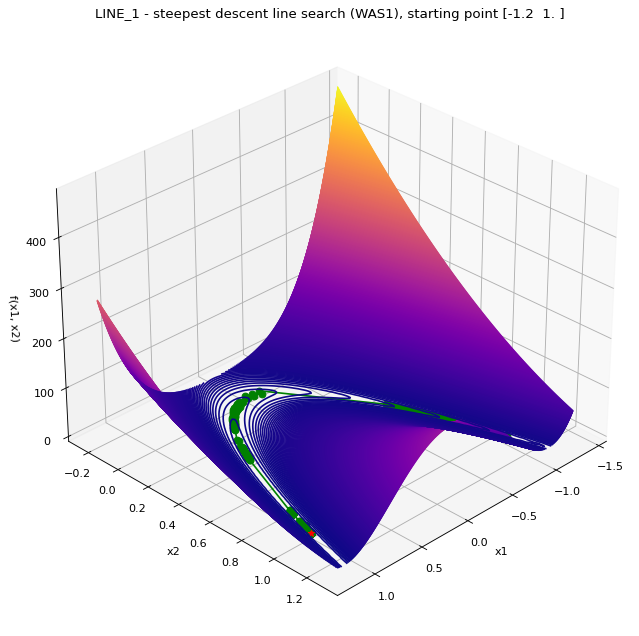

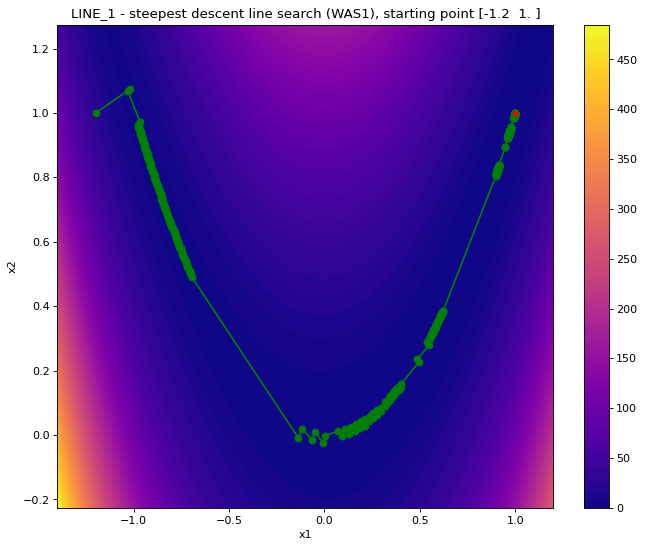

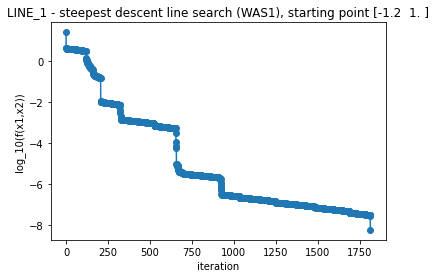

In [15]:
# LINE SEARCH

# set our functions to minimize
F = F_Rosenbrock
Gradient = Gradient_Rosenbrock
Hessian = Hessian_Rosenbrock

# set model functions
P = Steepest_Descent
Alpha = Wolfe_Alpha_Strategy1

# set global params
params={
    'alphaMax':1,
    'c1':1e-4, 
    'c2':0.9, 
    'epsilon':0}
tolerance = 1e-8

# starting point
x0 = np.array([-1.2, 1])

# save results for each trial
line_results = {}
line_trial_names = {}
trial = 'LINE_1'
line_trial_names[trial] = trial + ' - steepest descent line search (WAS1), starting point ' + str(x0)
print('Trial ' + line_trial_names[trial])
line_results[trial] = Line_Search(F, Gradient, Hessian, P, Alpha, tolerance, x0, params=params)


#### PLOT RESULTS

# change from numpy array input to two scalars
def F2(x1, x2):
    return 100 * (x2 - x1**2)**2 + (1-x1)**2

line_plt_trials = ['LINE_1']

# 3d plot for each trial
for trial in line_plt_trials:
    # get arrays
    n = len(line_results[trial])
    x1s = [None] * n
    x2s = [None] * n
    ys = [None] * n
    for i in range(n):
        x1s[i] = line_results[trial][i][0][0]
        x2s[i] = line_results[trial][i][0][1]
        ys[i] = line_results[trial][i][1]
    # plot
    fig = plt.figure(figsize=(10, 10), dpi=80)
    ax = plt.axes(projection='3d')
    X1, X2 = np.meshgrid(np.linspace(min(x1s)-0.2, max(x1s)+0.2, 100),
                         np.linspace(min(x2s)-0.2, max(x2s)+0.2, 100))
    Y = F2(X1, X2)
    ax.contour3D(X1, X2, Y, cmap='plasma', levels=1000)
    ax.set_xlabel('x1')
    ax.set_ylabel('x2')
    ax.set_zlabel('f(x1, x2)')
    ax.set_title(line_trial_names[trial])
    ax.view_init(30, 45)
    plt.plot(xs=x1s,ys=x2s,zs=ys, color='green', marker='o')
    plt.plot(xs=x1s[-1],ys=x2s[-1],zs=ys[-1], color='red', marker='*')
    plt.show()
    
# 2d plot for each trial
for trial in line_plt_trials:
    # plot path of line search
    n = len(line_results[trial])
    x1s = [None] * n
    x2s = [None] * n
    for i in range(n):
        x1s[i] = line_results[trial][i][0][0]
        x2s[i] = line_results[trial][i][0][1]
    X1, X2 = np.meshgrid(np.linspace(min(x1s)-0.2, max(x1s)+0.2, 100),
                         np.linspace(min(x2s)-0.2, max(x2s)+0.2, 100))
    Y = F2(X1, X2)
    fig, ax = plt.subplots(1,1,figsize=(10, 8), dpi=80)
    cp = ax.contourf(X1, X2, Y, cmap='plasma', levels=100)
    fig.colorbar(cp) # Add a colorbar to a plot
    ax.set_title(line_trial_names[trial])
    ax.set_xlabel('x1')
    ax.set_ylabel('x2')
    ax.plot(x1s, x2s, color='green', marker='o')
    ax.plot(x1s[-1], x2s[-1], color='red', marker='*')
    plt.show()
    
# f vs iteration plot
for trial in line_plt_trials:
    plt.title(line_trial_names[trial])
    plt.xlabel('iteration')
    plt.ylabel('log_10(f(x1,x2))')
    # plot path of line search
    n = len(line_results[trial])
    iters = [None] * n
    ys = [None] * n
    for i in range(n):
        iters[i] = i
        ys[i] = line_results[trial][i][1]
    plt.plot(np.array(iters), np.log10(np.array(ys)), marker='o')
    plt.show()

Trial TRUST_1 - CG-Sterling trust region, starting point [-1.2  1. ]
reached stopping criteria at iteration 0
reached trust region boundary at iteration 1
reached trust region boundary at iteration 2
reached trust region boundary at iteration 3
reached stopping criteria at iteration 4
reached stopping criteria at iteration 5
reached stopping criteria at iteration 6
reached stopping criteria at iteration 7
reached stopping criteria at iteration 8
reached trust region boundary at iteration 9
reached stopping criteria at iteration 10
reached trust region boundary at iteration 11
reached stopping criteria at iteration 12
reached trust region boundary at iteration 13
reached stopping criteria at iteration 14
reached stopping criteria at iteration 15
reached trust region boundary at iteration 16
reached stopping criteria at iteration 17
reached stopping criteria at iteration 18
reached stopping criteria at iteration 19
reached stopping criteria at iteration 20
reached stopping criteria at it

C:\Users\timkj\AppData\Local\Temp/ipykernel_16164/1045280710.py:3: RuntimeWarning: invalid value encountered in double_scalars
  return (f - F(x + p)) / (Model(f, gradient_T, np.zeros(p.shape), hessian) - Model(f, gradient_T, p, hessian))


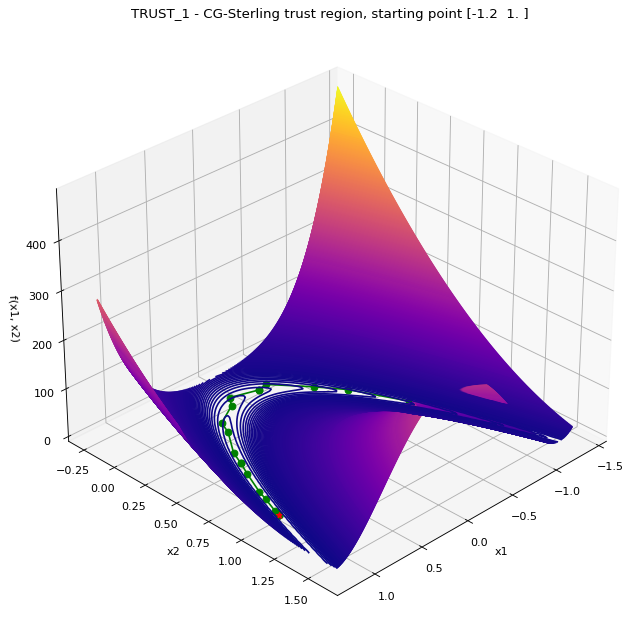

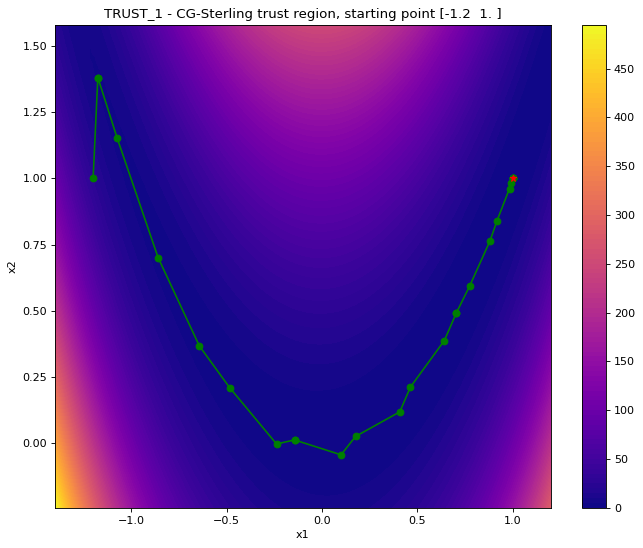

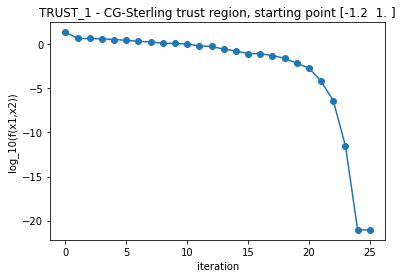

In [16]:
# TRUST REGION

# set function to minimize
F = F_Rosenbrock
Gradient = Gradient_Rosenbrock
Hessian = Hessian_Rosenbrock

# set model functions
Model = Quad_Model
P = CG_Steihaug_P

# set global params
tolerance = 1e-8
radiusMax = 300
radius = 1
eta = 1/4
c1 = 1/4
c2 = 1/4
c3 = 3/4
c4 = 2
params = {
    'eps_k':1e-8 # i tried using 1e-6 and results did not converge, so changed it to this
}

# starting point
x0 = np.array([-1.2, 1])

# get results
trust_results = {}
trust_trial_names = {}
trial = 'TRUST_1'
trust_trial_names[trial] = trial + ' - CG-Sterling trust region, starting point ' + str(x0)
print('Trial ' + trust_trial_names[trial])
trust_results[trial] = Trust_Region(F, Gradient, Hessian, x0, tolerance,
                                radiusMax, radius, eta, Model, P, c1, c2, c3, c4, params=params)


#### PLOT RESULTS

# change from numpy array input to two scalars
def F2(x1, x2):
    return 100 * (x2 - x1**2)**2 + (1-x1)**2

trust_plt_trials = ['TRUST_1']

# 3d plot for each trial
for trial in trust_plt_trials:
    # get arrays
    n = len(trust_results[trial])
    x1s = [None] * n
    x2s = [None] * n
    ys = [None] * n
    for i in range(n):
        x1s[i] = trust_results[trial][i][0][0]
        x2s[i] = trust_results[trial][i][0][1]
        ys[i] = trust_results[trial][i][1]
    # plot
    fig = plt.figure(figsize=(10, 10), dpi=80)
    ax = plt.axes(projection='3d')
    X1, X2 = np.meshgrid(np.linspace(min(x1s)-0.2, max(x1s)+0.2, 100),
                         np.linspace(min(x2s)-0.2, max(x2s)+0.2, 100))
    Y = F2(X1, X2)
    ax.contour3D(X1, X2, Y, cmap='plasma', levels=1000)
    ax.set_xlabel('x1')
    ax.set_ylabel('x2')
    ax.set_zlabel('f(x1, x2)')
    ax.set_title(trust_trial_names[trial])
    ax.view_init(30, 45)
    plt.plot(xs=x1s,ys=x2s,zs=ys, color='green', marker='o')
    plt.plot(xs=x1s[-1],ys=x2s[-1],zs=ys[-1], color='red', marker='*')
    plt.show()
    
# 2d plot for each trial
for trial in trust_plt_trials:
    # plot path of line search
    n = len(trust_results[trial])
    x1s = [None] * n
    x2s = [None] * n
    for i in range(n):
        x1s[i] = trust_results[trial][i][0][0]
        x2s[i] = trust_results[trial][i][0][1]
    X1, X2 = np.meshgrid(np.linspace(min(x1s)-0.2, max(x1s)+0.2, 100),
                         np.linspace(min(x2s)-0.2, max(x2s)+0.2, 100))
    Y = F2(X1, X2)
    fig, ax = plt.subplots(1,1,figsize=(10, 8), dpi=80)
    cp = ax.contourf(X1, X2, Y, cmap='plasma', levels=100)
    fig.colorbar(cp) # Add a colorbar to a plot
    ax.set_title(trust_trial_names[trial])
    ax.set_xlabel('x1')
    ax.set_ylabel('x2')
    ax.plot(x1s, x2s, color='green', marker='o')
    ax.plot(x1s[-1], x2s[-1], color='red', marker='*')
    plt.show()
    
# f vs iteration plot
for trial in trust_plt_trials:
    plt.title(trust_trial_names[trial])
    plt.xlabel('iteration')
    plt.ylabel('log_10(f(x1,x2))')
    # plot path of line search
    n = len(trust_results[trial])
    iters = [None] * n
    ys = [None] * n
    for i in range(n):
        iters[i] = i
        ys[i] = trust_results[trial][i][1]
    plt.plot(np.array(iters), np.log10(np.array(ys)), marker='o')
    plt.show()

In [17]:
# BFGS with n-dimensional data

# set initial x-values
xN = np.array([1., 1.])
x0easy = np.array([1.2, 1.2])
x0e2 = (xN+x0easy)/2
x0e3 = (xN+x0e2)/2
x0e4 = (xN+x0e3)/2
x0hard = np.array([-1.2, 1.0])
x0h2 = (xN+x0hard)/2
x0h3 = (xN+x0h2)/2
x0h4 = (xN+x0h3)/2
x0h5 = 2*x0hard
x0s = [
    x0easy,
    x0e2,
    x0e3,
    x0e4,
    x0hard,
    x0h2,
    x0h3,
    x0h4,
    x0h5
]
x0 = np.array([list(x) for x in x0s]).flatten()

# set our functions to minimize - ND = n-dimensional
F = F_Rosenbrock_ND
Gradient = Gradient_Rosenbrock_ND
Hessian = Hessian_Rosenbrock_ND

# set direction method and alpha method
P = Newton_P
Alpha = Backtracking_Alpha

# set global params
alpha0 = 1
c1 = 1e-4
c2 = 0.9
epsilon = 0.1
tolerance = 1e-8
alphaMax = 1
params={'alphaMax':alphaMax,'c1':c1, 'alpha0':1, 'rho':0.5, 'c2':c2, 'epsilon':epsilon}

# save results for each trial
bfgs_results = {}
bfgs_trial_names = {}

hessian0 = np.identity(len(x0)) # need an intial hessian (several methods for this)
trial = 'BFGS_1'
bfgs_results[trial] = BFGS(F, Gradient, Hessian, hessian0, P, Alpha, tolerance, x0, params)
bfgs_trial_names[trial] = trial

[inner_itertions, f(x), alpha, ||∇f(x*)||, 1e]

total_inner_iters=12844 total_outer_iters=1352 final_f(x*)=0.21735694396910302
